In [1]:
import torch
import json
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
# Dataset config
with open("../../config/config.json") as json_file:
    config = json.load(json_file)
    TIME_BEG = config["data"]["begin_timestamp"]
    # TIME_BEG = 1451606420 # = year 2016
    # TIME_BEG = 1483257600 # = year 2017
    # TIME_BEG = 1546347600 # = year 2019
    TIME_INTERVAL = config["data"]["time_interval"] // 60 # minutes
    INPUT_SERIE_LEN = config["data"]["input_serie_len"]
    OUTPUT_SERIE_LEN = config["data"]["output_serie_len"]
    INPUT_FEATURE_SIZE = config["model"]["input_feature_size"]
    OUTPUT_FEATURE_SIZE = config["model"]["output_feature_size"]
    
    print("Time interval: ", TIME_INTERVAL)
    print("Input serie length: ", INPUT_SERIE_LEN)
    print("Output serie length: ", OUTPUT_SERIE_LEN)
    print("Input feature size: ", INPUT_FEATURE_SIZE)
    print("Output feature size: ", OUTPUT_FEATURE_SIZE)
    

Time interval:  10
Input serie length:  100
Output serie length:  1
Input feature size:  4
Output feature size:  1


In [3]:
# Read csv file
prices = None
with open('kaggle_1min.csv', 'r') as f:
    reader = csv.reader(f)
    prices = list(reader)

In [4]:
# Process with Panda dataframe
prices_df = pd.DataFrame(prices[1:], columns=prices[0])
print("Original dataframe: \n", prices_df)

prices_df = prices_df.drop(columns=["Volume_(Currency)"])
prices_df = prices_df.astype(float)
prices_df = prices_df.fillna(0) # Replace NaN with 0 (time where trade volume = 0)
prices_df = prices_df.loc[prices_df["Timestamp"] >= TIME_BEG] # Cut off from desired begin time
prices_df = prices_df.reset_index(drop=True)

print("Processed dataframe: \n", prices_df)

Original dataframe: 
           Timestamp      Open      High       Low     Close Volume_(BTC)  \
0        1325317920      4.39      4.39      4.39      4.39   0.45558087   
1        1325317980       NaN       NaN       NaN       NaN          NaN   
2        1325318040       NaN       NaN       NaN       NaN          NaN   
3        1325318100       NaN       NaN       NaN       NaN          NaN   
4        1325318160       NaN       NaN       NaN       NaN          NaN   
...             ...       ...       ...       ...       ...          ...   
4727772  1609372560  28801.47  28829.42  28785.64  28829.42   0.96522104   
4727773  1609372620  28829.42   28863.9  28829.42  28857.06   2.36883117   
4727774  1609372680  28850.49  28900.52  28850.49  28882.82   2.46658976   
4727775  1609372740  28910.54  28911.52   28867.6   28881.3     7.332773   
4727776  1609372800  28893.21  28928.49  28893.21  28928.49   5.75767938   

        Volume_(Currency) Weighted_Price  
0            2.0000000

In [5]:
# Make col name to index map
cols = prices_df.columns
col_i = dict()
for i in range(len(cols)):
    col_i[cols[i]] = i
print(col_i)

{'Timestamp': 0, 'Open': 1, 'High': 2, 'Low': 3, 'Close': 4, 'Volume_(BTC)': 5, 'Weighted_Price': 6}


In [6]:
# Convert dataframe to torch tensor
prices_tensor = torch.from_numpy(prices_df.values)

In [7]:
# Fill values for timesteps with 0 trade volume
count = 0
for i in range(0, len(prices_tensor)):
    if prices_tensor[i, col_i["Volume_(BTC)"]] == 0 or prices_tensor[i, col_i["Low"]] < 200: # Fix a bad data with low price 1.5
        prices_tensor[i, col_i["Open"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["Close"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["High"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["Low"]] = prices_tensor[i-1, col_i["Close"]]
        prices_tensor[i, col_i["Weighted_Price"]] = prices_tensor[i-1, col_i["Close"]]
        count += 1
        
print("Fixed", str(count), "bad data out of ", str(len(prices_tensor)))

Fixed 25259 bad data out of  1050421


In [8]:
# Condense data by each TIME_INTERVAL, use Volume Weighted Average Price (VWAP)
num_data = prices_tensor.shape[0] // TIME_INTERVAL
shape = (num_data, len(col_i))
condensed_prices_tensor = torch.empty(shape)

count = 0
i = 0
j = 0
while i <= len(prices_tensor) - TIME_INTERVAL:
    condensed_prices_tensor[j, col_i["Timestamp"]] = prices_tensor[i, col_i["Timestamp"]] # Time stamp

    # Calculate WVAP
    volume_weighted_sum = torch.sum(prices_tensor[i:i+TIME_INTERVAL, col_i["Volume_(BTC)"]] * prices_tensor[i:i+TIME_INTERVAL, col_i["Weighted_Price"]])
    total_volume = torch.sum(prices_tensor[i:i+TIME_INTERVAL, col_i["Volume_(BTC)"]])
    wvap = volume_weighted_sum / total_volume
    
    # If no trade in this time interval use the price in the previous one
    # Here assume that first TIME_INTERVAL starting from TIME_BEG has non-zero trade volume
    if total_volume == 0:
        condensed_prices_tensor[j, col_i["Weighted_Price"]] = condensed_prices_tensor[j-1, col_i["Weighted_Price"]]
        count += 1
    else:
        condensed_prices_tensor[j, col_i["Weighted_Price"]] = wvap
        
    # Sum up candle stats
    condensed_prices_tensor[j, col_i["Open"]] = prices_tensor[i, col_i["Open"]] # Open price 
    condensed_prices_tensor[j, col_i["High"]] = torch.max(prices_tensor[i:i+TIME_INTERVAL, col_i["High"]]) # Highest price
    condensed_prices_tensor[j, col_i["Close"]] = prices_tensor[i+TIME_INTERVAL-1, col_i["Close"]] # Close price
    condensed_prices_tensor[j, col_i["Low"]] = torch.min(prices_tensor[i:i+TIME_INTERVAL, col_i["Low"]]) # Lowest price
    condensed_prices_tensor[j, col_i["Volume_(BTC)"]] = total_volume

    i += TIME_INTERVAL
    j += 1

print("Number of 0 volume time steps: ", str(count), "out of", str(len(condensed_prices_tensor)))

Number of 0 volume time steps:  54 out of 105042


In [9]:
# Check low high price validity
for i in range(len(condensed_prices_tensor)):
    assert(condensed_prices_tensor[i, col_i["Low"]] == torch.min(condensed_prices_tensor[i, 1:5]))
    assert(condensed_prices_tensor[i, col_i["High"]] == torch.max(condensed_prices_tensor[i, 1:5]))

In [10]:
print(condensed_prices_tensor.shape)
torch.sum((condensed_prices_tensor[:, col_i["High"]] > condensed_prices_tensor[:, col_i["Open"]]) * (condensed_prices_tensor[:, col_i["Low"]] < condensed_prices_tensor[:, col_i["Close"]]))

torch.Size([105042, 7])


tensor(92626)

Original price data shape:  torch.Size([1050421, 7])
Time condensed price data shape:  torch.Size([105042, 7])
Timestamp
Max Timestamp 1609372160.0
Min Timestamp 1546347648.0
Mean Timestamp 1577859712.0
Standard deviation of Timestamp 18193894.0

Open
Max Open 28997.380859375
Min Open 3346.5
Mean Open 9193.1015625
Standard deviation of Open 3933.458740234375

High
Max High 29010.3203125
Min High 3354.340087890625
Mean High 9210.6318359375
Standard deviation of High 3942.9541015625

Low
Max Low 28875.859375
Min Low 3322.18994140625
Mean Low 9174.80859375
Standard deviation of Low 3923.355712890625

Close
Max Close 28997.380859375
Min Close 3346.3701171875
Mean Close 9193.201171875
Standard deviation of Close 3933.922607421875

Volume_(BTC)
Max Volume_(BTC) 3289.6220703125
Min Volume_(BTC) 0.0
Mean Volume_(BTC) 57.66279220581055
Standard deviation of Volume_(BTC) 99.32701110839844

Weighted_Price
Max Weighted_Price 28949.5390625
Min Weighted_Price 3340.60009765625
Mean Weighted_Price 919

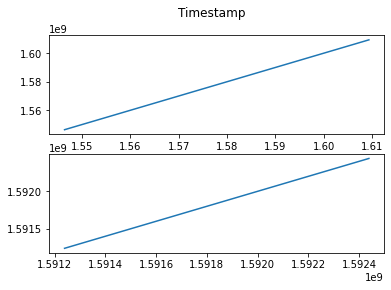

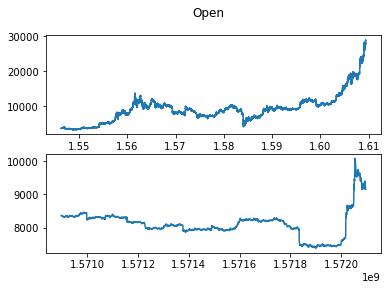

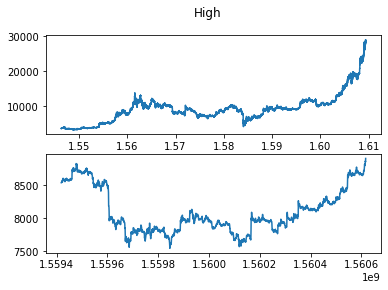

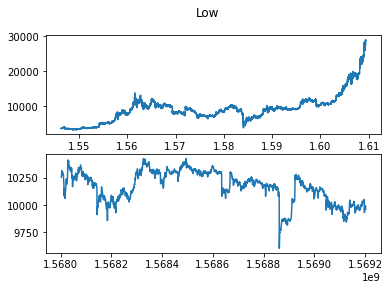

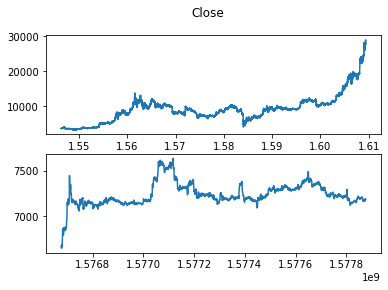

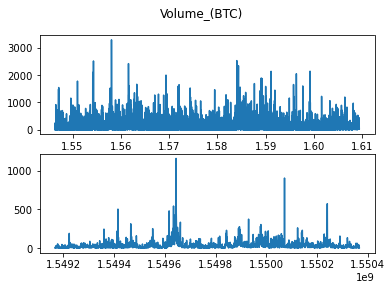

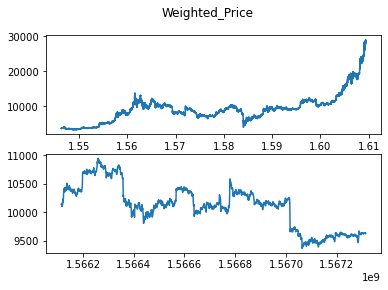

In [11]:
# Data summary and visualization
ZOOM_IN_SECTION_LEN = 2000

print("Original price data shape: ", prices_tensor.shape)
print("Time condensed price data shape: ", condensed_prices_tensor.shape)

for col_name in col_i:
    ind = col_i[col_name]
    x = condensed_prices_tensor[:, 0] # Time
    y = condensed_prices_tensor[:, ind]
    
    # Random section for zoomed in view
    rand_sec_i = random.randint(0, len(condensed_prices_tensor) - ZOOM_IN_SECTION_LEN)

    fig, axs = plt.subplots(2)
    fig.suptitle(col_name)
    axs[0].plot(x, y)
    axs[1].plot(x[rand_sec_i:rand_sec_i+ZOOM_IN_SECTION_LEN], y[rand_sec_i:rand_sec_i+ZOOM_IN_SECTION_LEN])

    mini = torch.min(condensed_prices_tensor[:,ind]).item()
    maxi = torch.max(condensed_prices_tensor[:,ind]).item()
    mean = torch.mean(condensed_prices_tensor[:,ind]).item()
    std = torch.std(condensed_prices_tensor[:,ind]).item()

    print(col_name)
    print("Max", col_name, maxi)
    print("Min", col_name, mini)
    print("Mean", col_name, mean)
    print("Standard deviation of", col_name, std)
    print()

In [12]:
# # Visualize sectional price data
# x = condensed_prices_tensor[126000:, 0] # Time
# y = condensed_prices_tensor[126000:, col_i["Weighted_Price"]]

# fig, axs = plt.subplots(1)
# fig.suptitle(col_name)
# axs.plot(x, y)


Max 162.9170379638672
Min -94.01509094238281
Mean 0.02376500330865383
Standard deviation 2.9128167629241943
percentile_lowest -1.2474751472473145
percentile_lower -0.3014807403087616
percentile_higher 0.37710392475128174
percentile_highest 1.3371260166168213


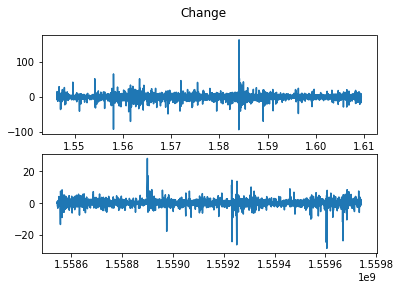

In [13]:
# weighted price -> weighted price rate of change                  
weighted_roc = (condensed_prices_tensor[1:, col_i["Weighted_Price"]] - condensed_prices_tensor[:-1, col_i["Weighted_Price"]]) / condensed_prices_tensor[:-1, col_i["Weighted_Price"]]
weighted_roc *= 1000

# Checking for nan data
assert(torch.sum(weighted_roc != weighted_roc) == 0)

mini = torch.min(weighted_roc).item()
maxi = torch.max(weighted_roc).item()
mean = torch.mean(weighted_roc).item()
std = torch.std(weighted_roc).item()
percentile_lowest = np.percentile(weighted_roc.numpy(), 20).item()
percentile_lower = np.percentile(weighted_roc.numpy(), 40).item()
percentile_higher = np.percentile(weighted_roc.numpy(), 60).item()
percentile_highest = np.percentile(weighted_roc.numpy(), 80).item()

print("Max", maxi)
print("Min", mini)
print("Mean", mean)
print("Standard deviation", std)
print("percentile_lowest", percentile_lowest)
print("percentile_lower", percentile_lower)
print("percentile_higher", percentile_higher)
print("percentile_highest", percentile_highest)

time_x = condensed_prices_tensor[1:, 0]
price_change_y = weighted_roc
section_start = random.randint(0, len(weighted_roc) - ZOOM_IN_SECTION_LEN)

fig, axs = plt.subplots(2)
fig.suptitle('Change')
axs[0].plot(time_x, price_change_y)
axs[1].plot(time_x[section_start:section_start+ZOOM_IN_SECTION_LEN], price_change_y[section_start:section_start+ZOOM_IN_SECTION_LEN])

weighted_roc = weighted_roc.reshape(-1, 1)


In [14]:
# Convert candle stats [open high low close] to percentage of last closing price
candle_stats = condensed_prices_tensor[1:, 1:5] / condensed_prices_tensor[:-1, col_i["Close"]].reshape(-1, 1) - 1
candle_stats *= 1000
assert(torch.sum(candle_stats != candle_stats) == 0)

In [15]:
print(torch.max(candle_stats[:, 0]))
print(torch.min(candle_stats[:, 0]))
print(torch.max(candle_stats[:, 1]))
print(torch.min(candle_stats[:, 1]))
print(torch.max(candle_stats[:, 2]))
print(torch.min(candle_stats[:, 2]))

tensor(9.6288)
tensor(-7.8251)
tensor(171.2975)
tensor(-3.2700)
tensor(3.5089)
tensor(-146.1749)


In [16]:
high_low_stats = candle_stats[:,1:3]

In [17]:
# Convert closing price to ROC
closing_price_roc = candle_stats[:, -1]
# closing_price_roc = (condensed_prices_tensor[1:, col_i["Close"]] - condensed_prices_tensor[:-1, col_i["Close"]]) / condensed_prices_tensor[:-1, col_i["Close"]] * 1000
closing_price_roc = closing_price_roc.reshape(-1,1)
assert(torch.sum(closing_price_roc != closing_price_roc) == 0)

In [18]:
# Normalize volume count
volumes = condensed_prices_tensor[1:, col_i["Volume_(BTC)"]]
mean_vol = torch.mean(volumes)
std_vol = torch.std(volumes)
volumes = (volumes - mean_vol) / std_vol
volumes = volumes.reshape(-1, 1)

In [19]:
# Slap all features together!
# data_in = weighted_roc
data_in = candle_stats
# data_in = torch.cat([candle_stats, closing_price_roc], dim=1)
    
# data_out = high_low_stats
data_out = closing_price_roc
# data_in = candle_stats
# data_out = torch.cat([high_low_stats, closing_price_roc], dim=1)

print(condensed_prices_tensor[:5])
print(data_in[:5])
print(data_out[:5])

assert(data_in.shape[0] == data_out.shape[0])
assert(data_in.shape[1] == INPUT_FEATURE_SIZE)
assert(data_out.shape[1] == OUTPUT_FEATURE_SIZE)

tensor([[1.5463e+09, 3.7109e+03, 3.7140e+03, 3.7059e+03, 3.7059e+03, 1.0729e+01,
         3.7125e+03],
        [1.5463e+09, 3.7084e+03, 3.7177e+03, 3.7072e+03, 3.7100e+03, 8.6038e+00,
         3.7087e+03],
        [1.5463e+09, 3.7103e+03, 3.7145e+03, 3.7063e+03, 3.7099e+03, 4.3971e+00,
         3.7083e+03],
        [1.5463e+09, 3.7099e+03, 3.7176e+03, 3.7083e+03, 3.7142e+03, 4.4772e+00,
         3.7122e+03],
        [1.5463e+09, 3.7142e+03, 3.7164e+03, 3.7111e+03, 3.7151e+03, 3.5550e+01,
         3.7151e+03]])
tensor([[ 0.6665,  3.1815,  0.3481,  1.0955],
        [ 0.0917,  1.2237, -0.9919, -0.0323],
        [ 0.0000,  2.0863, -0.4124,  1.1779],
        [ 0.0000,  0.5950, -0.8427,  0.2477],
        [ 0.0000,  8.7588, -0.9259,  0.8452]])
tensor([[ 1.0955],
        [-0.0323],
        [ 1.1779],
        [ 0.2477],
        [ 0.8452]])


In [20]:
# Make input time serie data and target time serie data tensor 
num_data = (data_in.shape[0] - INPUT_SERIE_LEN - OUTPUT_SERIE_LEN) // OUTPUT_SERIE_LEN + 1

X_shape = (num_data, INPUT_SERIE_LEN, INPUT_FEATURE_SIZE)
y_shape = (num_data, OUTPUT_SERIE_LEN, OUTPUT_FEATURE_SIZE)

X, y = torch.empty(X_shape), torch.empty(y_shape)

for i in range(num_data):
    start = i * OUTPUT_SERIE_LEN
    X[i] = data_in[start:start+INPUT_SERIE_LEN]
    y[i] = data_out[start+INPUT_SERIE_LEN:start+INPUT_SERIE_LEN+OUTPUT_SERIE_LEN] # Price is last feature


In [21]:
print("Encode time serie data shape:", X_shape)
print("Decode time serie data shape:", y_shape)
# print("Condensed data:\n", condensed_prices_tensor[:INPUT_SERIE_LEN+OUTPUT_SERIE_LEN+1])
print("Condensed data:\n", condensed_prices_tensor[:2])
print("Training X:\n", X[:3])
print("Training y:\n", y[:4])

Encode time serie data shape: (104941, 100, 4)
Decode time serie data shape: (104941, 1, 1)
Condensed data:
 tensor([[1.5463e+09, 3.7109e+03, 3.7140e+03, 3.7059e+03, 3.7059e+03, 1.0729e+01,
         3.7125e+03],
        [1.5463e+09, 3.7084e+03, 3.7177e+03, 3.7072e+03, 3.7100e+03, 8.6038e+00,
         3.7087e+03]])
Training X:
 tensor([[[ 0.6665,  3.1815,  0.3481,  1.0955],
         [ 0.0917,  1.2237, -0.9919, -0.0323],
         [ 0.0000,  2.0863, -0.4124,  1.1779],
         ...,
         [-0.5219,  2.0930, -0.5219,  1.9110],
         [-0.3841,  0.6998, -1.1681,  0.5367],
         [-0.9124,  0.0421, -0.9124,  0.0421]],

        [[ 0.0917,  1.2237, -0.9919, -0.0323],
         [ 0.0000,  2.0863, -0.4124,  1.1779],
         [ 0.0000,  0.5950, -0.8427,  0.2477],
         ...,
         [-0.3841,  0.6998, -1.1681,  0.5367],
         [-0.9124,  0.0421, -0.9124,  0.0421],
         [ 0.0000,  0.0000, -1.6328, -1.3699]],

        [[ 0.0000,  2.0863, -0.4124,  1.1779],
         [ 0.0000,  0.5950, 

In [22]:
torch.save(X, "./../X.pt")
torch.save(y, "./../y.pt")